## 0)import libraries 

In [1]:
"""
Thesis_PhD_Qianqian Predicted_fluxes_glboal_stripes
date: 24-Feb-2023
author: Qianqian
Contact: q.han@utwente.nl
-------------------------------------
Description: 
"""
# libraries
import os
import joblib
from osgeo import gdal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from rasterio.warp import reproject, Resampling
import xarray as xr
import pickle
from PyStemmusScope import variable_conversion as vc
from rasterio.warp import reproject, Resampling
from sklearn.preprocessing import OneHotEncoder
import time
import re
import glob
import rioxarray
import dask.array
from dask.distributed import Client, progress

In [2]:
# Set the MALLOC_TRIM_THRESHOLD_ environment variable
os.environ['MALLOC_TRIM_THRESHOLD_'] = '0'

# Run your Dask script or notebook
...

Ellipsis

In [3]:
# francesco
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(cores=16, memory='240GiB', queue='fat', processes=8, death_timeout=600, local_directory='$TMPDIR', walltime='5:00:00')
cluster.scale(jobs=1)

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://145.136.63.47:34871,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## 1)settings for Dask

In [4]:
# client = Client(n_workers=8, threads_per_worker=2)
# client

## 2)define working path, load trained model, define functions

In [5]:
workingPath = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/"

In [6]:
# load trained RF model, better use not parallel model with Dask
with open(workingPath+'3RF_train/RFLEH-LAI-hc-CO2-SSM-Vcmo-IGBP_multi7_1core_snellius0629.pkl', 'rb') as f:
    rfLEHmulti = pickle.load(f)

In [7]:
# function for loading the trained model
def load_model(path):
    # load trained RF model, better use not parallel model with Dask
    with open(path, 'rb') as f:
        rfLEHmulti = pickle.load(f)
    return rfLEHmulti

In [8]:
# function for getting directory of input data
def get_directories_with_number_and_ending(directory_path, ending):
    directories = []
    if ending:
        pattern = re.compile(r'^\d+.*{}$'.format(re.escape(ending)))  # Match directory names with number at the beginning and specific ending
    else:
        pattern = re.compile(r'^\d+$')  # Match directory names with only numbers

    for entry in os.scandir(directory_path):
        if entry.is_dir():
            directory_name = entry.name
            if pattern.match(directory_name):
                directories.append(directory_name)

    return directories

## 3) read data

In [9]:
### define the path of input data, set the reference file for spatial resample
inputData = workingPath+"1input_data/"
# get all the filefolders named as year
year_list = get_directories_with_number_and_ending(workingPath+"1input_data/", "NL")
# the input data from year[0] to year[..], based on the process id in sbatch script
year = year_list[3-1]
print(year)
# reference file for spatial resample
t = '2011-03-01T00:00:00.000000000'
era5 = xr.open_dataset(inputData+"/2017NL/era5land/era5-land_10m_u_component_of_wind_2017-01_FI-Hyy.nc")#.sel(time=t, method='nearest')['u10']

2017NL


In [10]:
### 0) read era5land data
all1 = xr.open_mfdataset(inputData+year+"/era5land/*.nc", chunks="auto")  # <- add the chunk size
all_resample = all1.resample(time="1800S").interpolate('linear')
all_resample = all_resample.isel(time=slice(0,17000))

In [11]:
all1.nbytes/2**30

0.6791044101119041

In [12]:
# calculate the Rin and Rli difference for every hour
Rin = all1['ssrd'].diff("time")/3600  #xr.concat([all1['ssrd'].isel(time=0),all1['ssrd']], dim="time")
Rin[0::24] = all1['ssrd'][1::24].values/3600 # assign the original values in t01
# Rin.mean(dim=['longitude','latitude']).compute()[48]
Rli = all1['strd'].diff("time")/3600  
Rli[0::24] = all1['strd'][1::24].values/3600
# Rli.mean(dim=['longitude','latitude']).plot()
Rin = Rin.resample(time="1800S").interpolate('linear')
Rli = Rli.resample(time="1800S").interpolate('linear')
Rin

<xarray.DataArray 'ssrd' (time: 17517, latitude: 51, longitude: 51)>
dask.array<transpose, shape=(17517, 51, 51), dtype=float32, chunksize=(17517, 51, 51), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 6.6 6.7 6.8 6.9 7.0
  * latitude   (latitude) float32 55.0 54.9 54.8 54.7 ... 50.3 50.2 50.1 50.0
  * time       (time) datetime64[ns] 2017-01-01T01:00:00 ... 2017-12-31T23:00:00

In [13]:
### 1) read LAI data
# probav_files = sorted(Path(inputData+year+"/lai/").glob("*.nc"))
# lai_10km = []
# for i in probav_files:
#     lai0 = xr.open_dataset(i)["LAI"].sel(lat=slice(55, 50), lon=slice(2, 7))
#     # print(lai.values)
#     lai0 = lai0.rio.write_crs('EPSG:4326')
#     era5 = era5.rio.write_crs('EPSG:4326')
#     lai0.rio.write_nodata(lai0.rio.nodata, inplace=True)
#     #好像不能同时重采样多个波段，不然nan值会互相影响。从python导出的LAI，然后在ArcGIS打开看着一样，但是在python里面，non-nan值的个数却不一样。
#     lai0_10km = lai0.rio.reproject_match(era5, resampling=Resampling.average)
#     lai0_10km = lai0_10km.assign_coords({
#         "x": lai0_10km.x,
#         "y": lai0_10km.y,
#     })
#     lai_10km.append(lai0_10km)
# lai = xr.concat(lai_10km, dim='time').resample(time="1800S").interpolate('linear').rename({'x':'longitude','y':'latitude'})
lai = xr.open_dataset(inputData+"/2017NL/lai/LAI_global2017_10km.nc")['LAI'].sel(latitude=slice(55, 50), longitude=slice(2, 7)).resample(time="1800S").interpolate('linear')

In [14]:
### 2) read canopy height data
hc_path = inputData+year+'/canopy_height/mosaic_output10km.tif'
hc = xr.open_dataset(hc_path, engine="rasterio").rename({'x':'longitude','y':'latitude'}).band_data

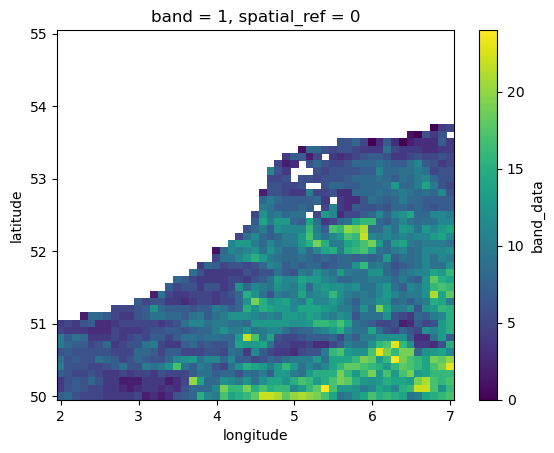

In [15]:
hc.plot()

In [16]:
### 3) read CO2 data
ds_co2 = xr.open_mfdataset(inputData+year+"/co2/CAMS_CO2_200*.nc", chunks="auto")['co2'].sel(time=year[:-2]).sel(latitude=slice(55, 50), longitude=slice(2, 7))
# convert unit: kg/kg to mg/m3
ds_co2 = vc.co2_mass_fraction_to_kg_per_m3(ds_co2)*1e6
# convert the longitude from [0, 360] to [-180, 180]
lon_name = 'longitude'
ds_co2['longitude_adjusted'] = xr.where(
    ds_co2[lon_name] > 180,
    ds_co2[lon_name] - 360,
    ds_co2[lon_name])
ds_co2 = (
    ds_co2
    .swap_dims({lon_name: 'longitude_adjusted'})
    .sel(**{'longitude_adjusted': sorted(ds_co2.longitude_adjusted)})
    .drop(lon_name))
ds_co2 = ds_co2.rename({'longitude_adjusted': lon_name})
ds_co2 = ds_co2.rio.write_crs('EPSG:4326')
era5 = era5.rio.write_crs('EPSG:4326')
ds_co2.rio.write_nodata(ds_co2.rio.nodata, inplace=True)
ds_co2_10km = ds_co2.rio.reproject_match(era5, resampling=Resampling.average)
ds_co2_10km = ds_co2_10km.assign_coords({
    "x": ds_co2_10km.x,
    "y": ds_co2_10km.y,
})
ds_co2_10km = ds_co2_10km.resample(time="1800S").interpolate('linear').rename({'x':'longitude','y':'latitude'})
#CO2有1483个波段，ERA5-Land有1487个波段。一个到21点，一个到23点。
#值得注意的是ERA5-Land的时间是每个step的结束时间，而CO2是每个step的开始时间？
#2011-03-01T00:30:00.000000000 在ERA5-Land代表的是00:00-00:30，而在CO2代表00:30-01:00？
ds_co2_10km=ds_co2_10km.assign_coords({'time':('time',ds_co2_10km.time.values + np.timedelta64(30,'m'),ds_co2_10km.time.attrs)})
#https://stackoverflow.com/questions/64737439/xarray-dataset-change-value-of-coordinates-while-keeping-attributes
# ds_co2_10km

In [17]:
## resampled CO2
# ds_co2_10km = xr.open_dataset(inputData+"/2017NL/co2/CAMS_CO2_2017_10km.nc")['co2'].sel(latitude=slice(55, 50), longitude=slice(2, 7)).resample(time="1800S").interpolate('linear')

In [18]:
### 4) read the resampled SSM data
## read the tif file, but the longitude and latitude is not overlapped with other variables
# path_SSM = glob.glob(inputData+year+"/ssm/SM2017Europe11kmNL20230814_10km.tif")[0]
# ds_SSM = xr.open_rasterio(path_SSM, engine="rasterio", decode_coords="all")
# ds_SSM = ds_SSM.sortby(["x", "y"])
# ds_SSM = ds_SSM.sel(x=slice(2,7.1), y=slice(50, 55))
# ds_SSM['band'] = pd.to_datetime(ds_SSM.band-1, unit='D', origin=str(path_SSM.split('/')[-1][2:6]))
# ds_SSM = ds_SSM.rename({'band':'time'})
# SSM = ds_SSM.resample(time="1800S").interpolate('linear').rename({'x':'longitude','y':'latitude'})/1000 
# SSM1 = SSM.sortby('latitude', ascending=False)

In [19]:
## netcdf file works well
path_SSM = glob.glob(inputData+year+"/ssm/SM2017Europe11kmNL20230814_10km.nc")[0]
ds_SSM = xr.open_dataset(path_SSM)['__xarray_dataarray_variable__'].rename('SSM')
ds_SSM = ds_SSM.sortby(["longitude", "latitude"])
ds_SSM = ds_SSM.sel(longitude=slice(2,7), latitude=slice(50, 55))
SSM = ds_SSM.resample(time="1800S").interpolate('linear')/1000 

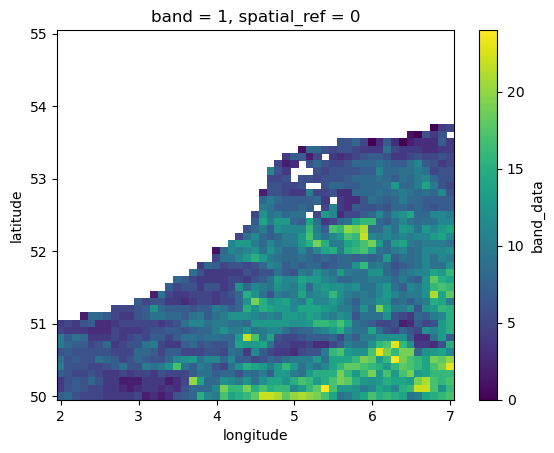

In [20]:
hc.plot()

In [21]:
### 5) read Vcmax data
ds_Vcmo = xr.open_rasterio(inputData+year+"/vcmax/TROPOMI_Vmax_Tg_mean10km_global.nc", engine="rasterio").rename({'x':'longitude','y':'latitude'})

/scratch-local/fnattino30.3957759/ipykernel_1386600/170410605.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds_Vcmo = xr.open_rasterio(inputData+year+"/vcmax/TROPOMI_Vmax_Tg_mean10km_global.nc", engine="rasterio").rename({'x':'longitude','y':'latitude'})


In [22]:
ds_Vcmo = ds_Vcmo.sel(longitude=slice(1.99,7), latitude=slice(55, 49.99))

In [23]:
ds_Vcmo

<xarray.DataArray (band: 1, latitude: 51, longitude: 51)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [25.09327 , 24.530003, ..., 10.87539 , 14.307365],
        [25.038637, 24.567535, ..., 14.127571, 15.572142]]], dtype=float32)
Coordinates:
  * band       (band) int64 1
  * latitude   (latitude) float64 55.0 54.9 54.8 54.7 ... 50.3 50.2 50.1 50.0
  * longitude  (longitude) float64 2.0 2.1 2.2 2.3 2.4 ... 6.6 6.7 6.8 6.9 7.0
Attributes:
    transform:   (0.09999999830410791, 0.0, -0.049999999152053956, 0.0, -0.1,...
    crs:         +init=epsg:4326
    res:         (0.09999999830410791, 0.1)
    is_tiled:    0
    nodatavals:  (nan,)
    scales:      (1.0,)
    offsets:     (0.0,)

In [24]:
### 6) read IGBP data
# read lan
path_landcover = inputData+year+"/igbp/landcover10km_global.nc"
landcover = xr.open_rasterio(path_landcover, engine="rasterio", chunks="auto").sel(x=slice(1.99,7), y=slice(55, 49.99)).rename({'x':'longitude','y':'latitude'})

/scratch-local/fnattino30.3957759/ipykernel_1386600/391389922.py:4: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  landcover = xr.open_rasterio(path_landcover, engine="rasterio", chunks="auto").sel(x=slice(1.99,7), y=slice(55, 49.99)).rename({'x':'longitude','y':'latitude'})


In [25]:
landcover

<xarray.DataArray (band: 1, latitude: 51, longitude: 51)>
dask.array<getitem, shape=(1, 51, 51), dtype=uint8, chunksize=(1, 51, 51), chunktype=numpy.ndarray>
Coordinates:
  * band       (band) int64 1
  * latitude   (latitude) float64 55.0 54.9 54.8 54.7 ... 50.3 50.2 50.1 50.0
  * longitude  (longitude) float64 2.0 2.1 2.2 2.3 2.4 ... 6.6 6.7 6.8 6.9 7.0
Attributes:
    transform:   (0.09999999830410791, 0.0, -0.049999999152053956, 0.0, -0.1,...
    crs:         +init=epsg:4326
    res:         (0.09999999830410791, 0.1)
    is_tiled:    0
    nodatavals:  (255.0,)
    scales:      (1.0,)
    offsets:     (0.0,)

In [26]:
# read IGBP unique values
data = pd.read_csv(inputData+'IGBP11unique.csv')['0'].unique()
# read the table for converting landcover to IGBP
IGBP_table = pd.read_csv(inputData+year+"/igbp/lccs_to_igbp_table.csv")

In [27]:
def landcover_to_igbp(landcover, IGBP_table, data):
    IGBP = np.vectorize(IGBP_table.set_index("lccs_class").T.to_dict('records')[0].get)(landcover.values)
    IGBP_all = pd.DataFrame(columns=['IGBP_veg_long1', 'IGBP_veg_long2', 'IGBP_veg_long3','IGBP_veg_long4','IGBP_veg_long5',
                              'IGBP_veg_long6','IGBP_veg_long7','IGBP_veg_long8','IGBP_veg_long9',
                             'IGBP_veg_long10','IGBP_veg_long11'])
    # define one hot encoding for IGBP
    encoder = OneHotEncoder(categories=[data]*1,sparse=False,
                           handle_unknown = "ignore")
    # transform data
    aa = encoder.fit_transform(IGBP.reshape(IGBP.shape[1]*IGBP.shape[1],1))
    # assign 23-D IGBP into 23 columns
    for i in range(1,12,1):
        IGBP_all['IGBP_veg_long'+str(i)] = aa[:,i-1]
    return IGBP_all

## 4) chunk all the input variables

In [28]:
ds_era5land = all_resample#.sel(time=t, method='nearest')#.compute()

ds_ss = xr.Dataset()
ds_ss["Rin"] = Rin.isel(time=slice(0,17000))#.sel(time=t, method='nearest')#.compute()
ds_ss["Rli"] = Rli.isel(time=slice(0,17000))#.sel(time=t, method='nearest')#.compute()
ds_ss["p"] = all_resample["sp"]/100   # Pa -> hPa
ds_ss["Ta"] = all_resample["t2m"] - 273.15  # K -> degC
ds_ss["ea"] = vc.calculate_es(all_resample["d2m"] - 273.15)
ds_ss["u"] = (all_resample["u10"] ** 2 + all_resample["v10"] ** 2) ** 0.5
ds_ss["Precip_msr"] = all_resample["tp"]*1000   # mm
ds_ss['LAI'] = lai.chunk()#.sel(time=t, method='nearest')#.compute()
ds_ss['CO2'] = ds_co2_10km.chunk()#.sel(time=t, method='nearest')#.compute()
ds_ss['SSM'] = SSM.chunk()#.sel(time=t, method='nearest')#.compute()

ds_ss = ds_ss.assign_coords({"longitude": hc.longitude.values, "latitude": hc.latitude.values})
ds_Vcmo = ds_Vcmo.assign_coords({"longitude": hc.longitude.values, "latitude": hc.latitude.values})
landcover = landcover.assign_coords({"longitude": hc.longitude.values, "latitude": hc.latitude.values})
ds_ss = ds_ss.isel(time=slice(0,17000))


In [29]:
ds_ss.nbytes/2**30

2.141502521932125

## 5) predict fluxes with map_blocks

In [30]:
ds_ss = ds_ss.to_array()

In [31]:
ds_ss = ds_ss.chunk({"time":2000, "variable":10})

In [32]:
ds_ss

<xarray.DataArray (variable: 10, time: 17000, latitude: 51, longitude: 51)>
dask.array<rechunk-merge, shape=(10, 17000, 51, 51), dtype=float64, chunksize=(10, 2000, 51, 51), chunktype=numpy.ndarray>
Coordinates:
  * longitude    (longitude) float64 2.0 2.1 2.2 2.3 2.4 ... 6.6 6.7 6.8 6.9 7.0
  * latitude     (latitude) float64 55.0 54.9 54.8 54.7 ... 50.3 50.2 50.1 50.0
  * time         (time) datetime64[ns] 2017-01-01T01:00:00 ... 2017-12-21T04:...
    spatial_ref  int64 0
  * variable     (variable) object 'Rin' 'Rli' 'p' 'Ta' ... 'LAI' 'CO2' 'SSM'

In [33]:
hc=hc.chunk().squeeze()
ds_Vcmo = ds_Vcmo.chunk().squeeze()
landcover = landcover.squeeze()

In [34]:
chunks = [ds_ss.chunksizes[v] for v in ['time', 'latitude', 'longitude']]
chunks.append((7,))

In [35]:
ds_ss = ds_ss.persist()
hc = hc.persist()
ds_Vcmo = ds_Vcmo.persist()
landcover = landcover.persist()

In [36]:
estimated_LEH = xr.DataArray(
    name = 'LEH',
    data=dask.array.zeros((len(ds_ss.time), len(ds_ss.latitude), len(ds_ss.longitude),7), chunks=chunks),
    dims=("time", "latitude", "longitude","variable_out"),
    coords={
        "variable_out":range(7), 
        "time":ds_ss.time, 
        "latitude":ds_ss.latitude,
        "longitude":ds_ss.longitude
    }
)

In [37]:
def predictFlux(ds_ss, hc, ds_Vcmo, landcover, IGBP_table, training_testing_append, path_model):
    # ds_ss = ds_ss.reshape(10,-1)
    # time = ds_ss.time
    # ds_ss = ds_ss.squeeze("time")
    hc_line = np.tile(hc.to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size) #如果和动态变量一样放进ds_ss里显示为一些离散的点，不知道为什么，所以静态变量放在时间循环外面
    Vcmo_line = np.tile(ds_Vcmo.to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP_all = landcover_to_igbp(landcover, IGBP_table, training_testing_append)
    IGBP1 = np.tile(IGBP_all.iloc[:,0].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP2 = np.tile(IGBP_all.iloc[:,1].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP3 = np.tile(IGBP_all.iloc[:,2].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP4 = np.tile(IGBP_all.iloc[:,3].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP5 = np.tile(IGBP_all.iloc[:,4].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP6 = np.tile(IGBP_all.iloc[:,5].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP7 = np.tile(IGBP_all.iloc[:,6].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP8 = np.tile(IGBP_all.iloc[:,7].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP9 = np.tile(IGBP_all.iloc[:,8].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP10 = np.tile(IGBP_all.iloc[:,9].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP11 = np.tile(IGBP_all.iloc[:,10].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    
    
    Rin_line = ds_ss[0,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    Rli_line = ds_ss[1,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    p_line = ds_ss[2,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    Ta_line = ds_ss[3,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    ea_line = ds_ss[4,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    u_line = ds_ss[5,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    Precip_msr_line = ds_ss[6,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    LAI_line = ds_ss[7,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    CO2_line = ds_ss[8,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    SSM_line = ds_ss[9,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)

    features_arr = np.concatenate((Rin_line, Rli_line, p_line, Ta_line,ea_line, u_line, Precip_msr_line,
                                   LAI_line, hc_line, CO2_line, SSM_line, Vcmo_line,
                                   IGBP1, IGBP2, IGBP3,IGBP4,IGBP5,IGBP6,IGBP7,IGBP8,IGBP9,IGBP10,IGBP11))
    features_arr = features_arr.transpose()
    # Nan value.
    df_features = pd.DataFrame(data=features_arr)
    df_features_drop_nan = df_features.dropna()
    invalid_index = sorted(set(df_features.index.to_list()) - set(df_features_drop_nan.index.to_list()))

    # # Convert the nan value as 0 for the calculation
    where_are_NaNs = np.isnan(features_arr)
    features_arr[where_are_NaNs] = 0
    
    model = load_model(path_model)
    
    # model = path_model
    estimated_LEH = model.predict(features_arr)
    estimated_LEH[invalid_index] = np.nan
    LEH_map = estimated_LEH.reshape(ds_ss.time.size, ds_ss.latitude.size, ds_ss.longitude.size,7)
    
    return xr.DataArray(
        name = 'LEH',
        data=LEH_map,
        dims=("time", "latitude", "longitude","variable_out"),
        coords={
            "variable_out":range(7), 
            "time":ds_ss.time, 
            "latitude":ds_ss.latitude,
            "longitude":ds_ss.longitude
        }
    )

In [38]:
result = xr.map_blocks(
    predictFlux,
    ds_ss,#.to_array().chunk({"time":1, "variable":10}),
    args=[hc, ds_Vcmo, landcover],
    kwargs={"IGBP_table":IGBP_table, "training_testing_append":data, "path_model":'/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/3RF_train/RFLEH-LAI-hc-CO2-SSM-Vcmo-IGBP_multi7_1core_snellius0629.pkl'},
    template=estimated_LEH,
)

In [39]:
result

<xarray.DataArray 'LEH' (time: 17000, latitude: 51, longitude: 51,
                         variable_out: 7)>
dask.array<<this-array>-predictFlux, shape=(17000, 51, 51, 7), dtype=float64, chunksize=(2000, 51, 51, 7), chunktype=numpy.ndarray>
Coordinates:
  * variable_out  (variable_out) int64 0 1 2 3 4 5 6
  * time          (time) datetime64[ns] 2017-01-01T01:00:00 ... 2017-12-21T04...
  * latitude      (latitude) float64 55.0 54.9 54.8 54.7 ... 50.3 50.2 50.1 50.0
  * longitude     (longitude) float64 2.0 2.1 2.2 2.3 2.4 ... 6.7 6.8 6.9 7.0

In [41]:
start_time = time.time()  # Record the start time
result1 = result.compute()
end_time = time.time()  # Record the end time
total_running_time = end_time - start_time
print("Total Running Time:", total_running_time)

Total Running Time: 2.364614963531494


In [42]:
result1

<xarray.DataArray 'LEH' (time: 17000, latitude: 51, longitude: 51,
                         variable_out: 7)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * variable_out  (variable_out) int64 0 1 2 3 4 5 6
  * time          (time) datetime64[ns] 2017-01-01T01:00:00 ... 2017-12-21T04...
  * latitude      (latitude) float64 55.0 54.9 54.8 54.7 ... 50.3 50.2 50.1 50.0
  * longitude     (longitude) float64 2.0 2.1 2.2 2.3 2.4 ... 6.7 6.8 6.9 7.0

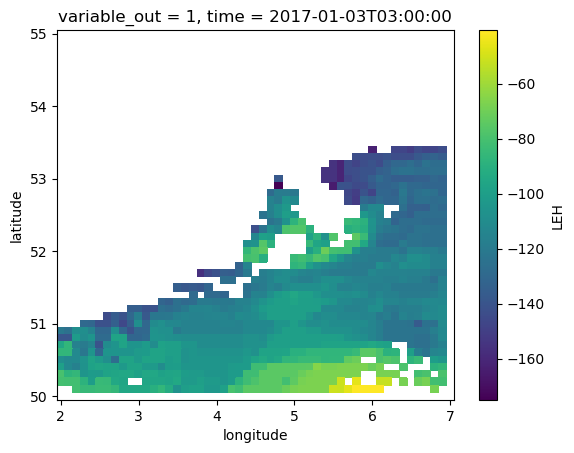

In [43]:
result1[100,:,:,1].plot() 
## I read SSM geoTiff file in this run, so the longitude and latitude was not overlapped with other variables, 
## but I changed to resampled SSM netCDF file(I rerun the 2000 timesteps after this change), the result is normal now.

## export the result